In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)
import umap
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from joblib import dump, load
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

In [2]:
# data import

# training dataset
train_set = "https://raw.githubusercontent.com/Programming-Systems-Lab/Capstone-2/master/data/Training_Data/Dataset_for_threshold.csv"
X = pd.read_csv(train_set)
# training labels
train_label = "https://raw.githubusercontent.com/Programming-Systems-Lab/Capstone-2/master/data/Training_Data/Labels_for_threshold.csv"
train_labels = pd.read_csv(train_label)

In [3]:
# obtain zero variance columns
zero_var_cols = X.columns[X.nunique()==1].to_list()
# Drop features with 0 variance
X.drop(zero_var_cols, axis = 1, inplace = True)

In [4]:
# drop duplicate rows
X = X[~X.duplicated(keep='first')]
y = train_labels['label']

In [5]:
print(X.shape)
print(y.shape)

(14084, 346)
(14084,)


In [6]:
# irrelevant columns
useless_cols = ['SHA256', 'Package_Name', 'ThumbPrint', 'Application_Category', 
                'Family_Name', 'Malware_Category', 'Malware/Benign',
                'sdkVersion', 'targetSdkVersion']

In [7]:
# sensor related columns
sensor_cols = X.loc[:, 'accelerometer':'temperature'].columns.to_list()
print(sensor_cols)

['accelerometer', 'gravity', 'gyroscope', 'light', 'linear_acceleration', 'magnetic_field', 'orientation', 'proximity', 'rotation_vector', 'temperature']


In [8]:
# obtain list of features
features = X.drop(columns=useless_cols).columns.to_list()
print("Number of features (with sensors):", len(features))

Number of features (with sensors): 337


In [9]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify = y)

In [10]:
print(X_train[features].shape)
print(X_test[features].shape)

(11267, 337)
(2817, 337)


In [11]:
# summary statistics of threshold
X['Malware/Benign'].describe()

count    14084.000000
mean         8.590954
std          8.364226
min          0.000000
25%          1.000000
50%          7.000000
75%         15.000000
max         46.000000
Name: Malware/Benign, dtype: float64

In [20]:
lower_thresholds = np.arange(5)
upper_thresholds = np.arange(5,26,5)

print(lower_thresholds)
print(upper_thresholds)

[0 1 2 3 4]
[ 5 10 15 20 25]


In [21]:
results = pd.DataFrame()
# column names of final results
columns = ['upper_threshold', 'lower_threshold', 'train_size', 'test_size', 'percentage_malware', 'balanced accuracy',
          'benign_precision', 'malware_precision', 'benign_recall', 'malware_recall']

# define thresholds
lower_thresholds = np.arange(5)
upper_thresholds = np.arange(5,26,5)

for lower_threshold in lower_thresholds:
    for upper_threshold in upper_thresholds:
        # only keep apps that are benign or malicious
        X_train_t = X_train[(X_train['Malware/Benign']<=lower_threshold)|(X_train['Malware/Benign']>=upper_threshold)]
        # change labels accordingly
        y_train_t = np.array([1 if p>=upper_threshold else 0 for p in X_train_t['Malware/Benign']])
        # only keep apps that are benign or malicious
        X_test_t = X_test[(X_test['Malware/Benign']<=lower_threshold)|(X_test['Malware/Benign']>=upper_threshold)]
        # change labels accordingly
        y_test_t = np.array([1 if p>=upper_threshold else 0 for p in X_test_t['Malware/Benign']])
    
    
    
        # NEED TO MODIFY
        # define model
        model_with_sensor = SVC(class_weight='balanced', C=1)
    
    
    
        # fit on new training data
        model_with_sensor.fit(X_train_t[features], y_train_t)
        # get predictions
        y_pred = model_with_sensor.predict(X_test_t[features])
        # calculate balanced accuracy
        bal_acc=balanced_accuracy_score(y_test_t, y_pred)
        # calculate precision
        benign_prec, malware_prec = precision_score(y_test_t, y_pred,average=None)
        # calculate recall
        benign_rec, malware_rec =  recall_score(y_test_t, y_pred,average=None)
        # obtain training data sample size
        train_size = len(y_train_t)
        # obtain test data sample size
        test_size = len(y_test_t)
        malware_percentage = (sum(y_train_t)+sum(y_test_t))/(len(y_train_t)+len(y_test_t))
    
        # add metrics to results
        df_threshold = pd.DataFrame([[upper_threshold, lower_threshold, train_size, test_size, malware_percentage, 
                                      bal_acc, benign_prec, malware_prec, benign_rec, malware_rec]],columns=columns)
        results = pd.concat([results, df_threshold])
        print("Upper:", upper_threshold, "Lower:", lower_threshold)
# reset index
results.reset_index(drop=True, inplace=True)

Upper: 5 Lower 0
Upper: 10 Lower 0
Upper: 15 Lower 0
Upper: 20 Lower 0
Upper: 25 Lower 0
Upper: 5 Lower 1
Upper: 10 Lower 1
Upper: 15 Lower 1
Upper: 20 Lower 1
Upper: 25 Lower 1
Upper: 5 Lower 2
Upper: 10 Lower 2
Upper: 15 Lower 2
Upper: 20 Lower 2
Upper: 25 Lower 2
Upper: 5 Lower 3
Upper: 10 Lower 3
Upper: 15 Lower 3
Upper: 20 Lower 3
Upper: 25 Lower 3
Upper: 5 Lower 4
Upper: 10 Lower 4
Upper: 15 Lower 4
Upper: 20 Lower 4
Upper: 25 Lower 4


In [22]:
results.head()

,upper_threshold,lower_threshold,train_size,test_size,percentage_malware,balanced accuracy,benign_precision,malware_precision,benign_recall,malware_recall
0,5,0,7619,1919,0.789893,0.885990,0.673624,0.966954,0.885287,0.886693
1,10,0,6595,1670,0.757532,0.892993,0.713439,0.965636,0.900249,0.885737
2,15,0,4718,1174,0.659878,0.879036,0.860104,0.912437,0.827930,0.930142
3,20,0,2636,664,0.392727,0.854745,0.940299,0.738602,0.785536,0.923954
4,25,0,2050,519,0.219930,0.919724,0.971429,0.798507,0.932668,0.906780


In [23]:
results.tail()

,upper_threshold,lower_threshold,train_size,test_size,percentage_malware,balanced accuracy,benign_precision,malware_precision,benign_recall,malware_recall
20,5,4,11267,2817,0.534933,0.869104,0.821478,0.912509,0.906851,0.831357
21,10,4,10243,2568,0.488721,0.880636,0.848527,0.922067,0.931486,0.829787
22,15,4,8366,2072,0.372485,0.875540,0.893197,0.889362,0.939954,0.811125
23,20,4,6284,1562,0.165180,0.854098,0.971171,0.511062,0.829869,0.878327
24,25,4,5698,1417,0.079410,0.926443,0.990415,0.642424,0.954580,0.898305


In [24]:
a = np.array(results['balanced accuracy']).reshape((5, 5))
a

array([[0.8859899 , 0.89299309, 0.87903624, 0.85474527, 0.919724  ],
       [0.89065307, 0.89571244, 0.88555309, 0.85755193, 0.93479479],
       [0.88392857, 0.88985984, 0.8856342 , 0.85605487, 0.93298167],
       [0.87394787, 0.88621081, 0.88058252, 0.85675904, 0.9322911 ],
       [0.86910424, 0.8806365 , 0.87553965, 0.85409806, 0.92644277]])

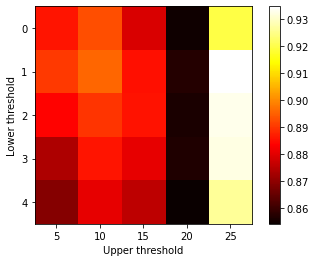

In [25]:

plt.imshow(a, cmap='hot')
plt.xlabel("Upper threshold")
plt.ylabel("Lower threshold")
plt.xticks(ticks = np.arange(5), labels=upper_thresholds)
plt.yticks(ticks = np.arange(5), labels=lower_thresholds)
plt.colorbar()
plt.show()

In [26]:
results.to_csv('thresholds_SVM_1205.csv', index=False)